In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
from pylab import *

In [2]:
#import outputs (7 parameters)
data = np.load("labels_cnn.npy")
data.shape

(5000, 7)

In [3]:
#load FROG traces corresponding to above parameters (inputs)
FROGS = np.load("FROG_test.npy")

## Data Pre-Processing

In [4]:
FROGS = FROGS.reshape(5000,128,128,1)

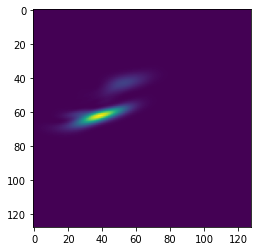

In [25]:
plt.imshow(FROGS[300])
plt.show()

In [40]:
X_orig = np.log(FROGS)
#X_orig = FROGS
a_max = np.max(X_orig)
b_min = np.min(X_orig)
X_orig = (2*X_orig - a_max - b_min)/(a_max - b_min)
X_train = X_orig[:4700,:,:]
X_test = FROGS[4700:, :, :]

In [42]:
Y = np.zeros([5000,7])
Y[:,0] = (2*data[:,0] - 1000 - 300)/(1000-300)
Y[:,1] = (2*data[:,1] - 1000 - 300)/(1000-300)
Y[:,2] = (2*data[:,2] - 1.5 - 0.6)/(1.5-0.6)
Y[:,3] = (2*data[:,3] - 1.5 - 0.6)/(1.5-0.6)
Y[:,4] = (2*data[:,4] - 0.005 + 0.005)/(0.005 + 0.005)
Y[:,5] = (2*data[:,5] - 0.0005 + 0.0005)/(0.0005 + 0.0005)
Y[:,6] = (2*data[:,6] - 5000 + 1000)/(5000+1000)

In [43]:
Y_train = Y[:4700,:]
Y_test = Y[4700:,:]

## Machine Learning Algorithm

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
model.add(MaxPooling2D((2,2), padding="valid"))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), padding="valid"))
model.add(Conv2D(16, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2), padding="valid"))
model.add(Flatten())
model.add(Dense(7, activation='tanh'))

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                

In [47]:
model.compile(optimizer="adam", loss="mae", metrics=["accuracy"])

In [48]:
sol = model.fit(X_train, Y_train, epochs=5, batch_size=128)

Epoch 1/5
4700/4700 [==============================] - 176s 37ms/step - loss: 0.5101 - accuracy: 0.1534
Epoch 2/5
4700/4700 [==============================] - 167s 35ms/step - loss: 0.5000 - accuracy: 0.1721
Epoch 3/5
4700/4700 [==============================] - 182s 39ms/step - loss: 0.4800 - accuracy: 0.2091
Epoch 4/5
4700/4700 [==============================] - 154s 33ms/step - loss: 0.4506 - accuracy: 0.2764
Epoch 5/5
4700/4700 [==============================] - 159s 34ms/step - loss: 0.4256 - accuracy: 0.3319


## Additional Functions for making trace plots

In [11]:
import sys

In [12]:
e0 = np.loadtxt('837nm.dat')		#load the reference pulse, pump @836 nm
e0 = e0.T
e1 = np.sqrt(e0[1])
e1_ph = e0[2]
e = np.array(e1)*np.exp(-1j*(np.array(e1_ph)))		#reforming E-field

original_trace = np.loadtxt('trace/trace1.frg')		#load FROG trace from experiment

N = len(e0[0])		#timesteps
N_max = np.max(e0[0])
N_min = np.min(e0[0])

t = e0[0]-N_min
T0 = N_max-N_min	#total time duration
dt = T0/(N-1)
df = 1.0/T0		#frequency steps
TD = N			#time delay for FROG-trace generation
freq = np.arange(0,1/dt+df,df)*1000

In [13]:
## for generation of Gaussian pulses
def gaussian_pulse(T,f,A,phase,tau):
	w0 = f*2*np.pi		#central angular frequency of pulse
	temp = -1j*w0*(t-tau) + 1j*phase
	E = A*np.sqrt(np.exp(-4.0*np.log(2.0)/np.log(np.e)*((t-tau)/T)**2))*np.exp(-temp)
	return E

In [14]:
## calculate cross correlation of two pulses
def xcorr(e0,e,td):		#shift one pulse by time delay of 'td'
	E_delay = e*1.0
	if td<=0:
		E_delay[0:N+td] = e0[-td:]
		E_delay[N+td:] = [0]*(-td)
	else:
		E_delay[0:td] = [0]*(td)
		E_delay[td:] = e0[0:N-td]	
	return  e*E_delay

In [15]:
## calculate the differert of trace A and trace B
def array_diff(A,B):
	A = A/np.max(A)
	B = B/np.max(B)
	return np.sum(np.square(A-B))/np.sum(np.square(A))

In [16]:
def FROG_generator(e,E,TD):	
	FROG = np.zeros((TD,N),dtype=float)
	for td in range(-TD//2,TD//2):
		E_corre = xcorr(e,E,td)
		temp0 = np.fft.fftshift(np.fft.fft(E_corre))
		FROG[(td+TD//2)-1] = abs(temp0)**2	
	return FROG.T

In [17]:
## calculate FROG traces with different time delays
def FROGs(T1,T2,A1,A2,f0,f1,tau1):
    tau2 = tau1-700
    phase1 = a2*(t-tau1)**2+a3*(t-tau1)**3
    phase2 = a2*(t-tau2)**2+a3*(t-tau2)**3 
    E1 = gaussian_pulse(T1,f0,A1,phase1,tau1)
    E2 = gaussian_pulse(T2,f1,A2,phase2,tau2)
    E = E1+E2
    FROG = FROG_generator(e,E,TD)
    delta = array_diff(FROG, original_trace)	
    return FROG, delta

In [18]:
## plot out FROG trace
def FROG_trace_plot(FROG):
	fig,ax = plt.subplots()
	plt.imshow(FROG)
	plt.title("FROG trace")
	plt.grid(True)
	plt.show()

In [19]:
a2 = 2.50*10**-6
a3 = 3.0*10**-9

## Prediction Function for model

In [20]:
def plot_trace(params):
    print(params)
    t1 = (params[0]*(1000-300) + 1000 + 300)/2
    t2 = (params[1]*(1000-300) + 1000 + 300)/2
    A1 = (params[2]*(1.5-0.6) + 1.5 + 0.6)/2
    A2 = (params[3]*(1.5-0.6) + 1.5 + 0.6)/2
    f0 = params[4]*0.005
    f1 = params[5]*0.0005
    tau1 = (params[6]*(5000+1000) - 1000 + 5000)/2
    (FROG,_) = FROGs(t1, t2, A1, A2, f0, f1, tau1)
    FROG_trace_plot(FROG)
    return FROG

In [21]:
def predict_trace(trace):
    y_pred = model.predict(trace).reshape(7)
    frog = plot_trace(y_pred)
    return frog

[-0.28778762 -0.19726445  0.09802631  0.00303089 -0.1784984  -0.09536018
 -0.98929924]


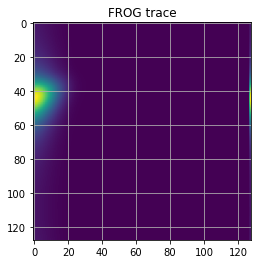

In [49]:
f1 = predict_trace(X_train[100].reshape(1,128,128,1))
#FROG_trace_plot(X_train[3000])

[-0.37142857 -0.4        -1.         -0.55555556 -0.9         0.3
 -0.53333333]


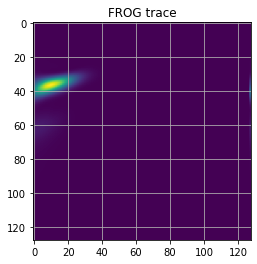

In [50]:
f2 = plot_trace(Y_train[100])

In [51]:
array_diff(f1, f2)

0.6817744222626461

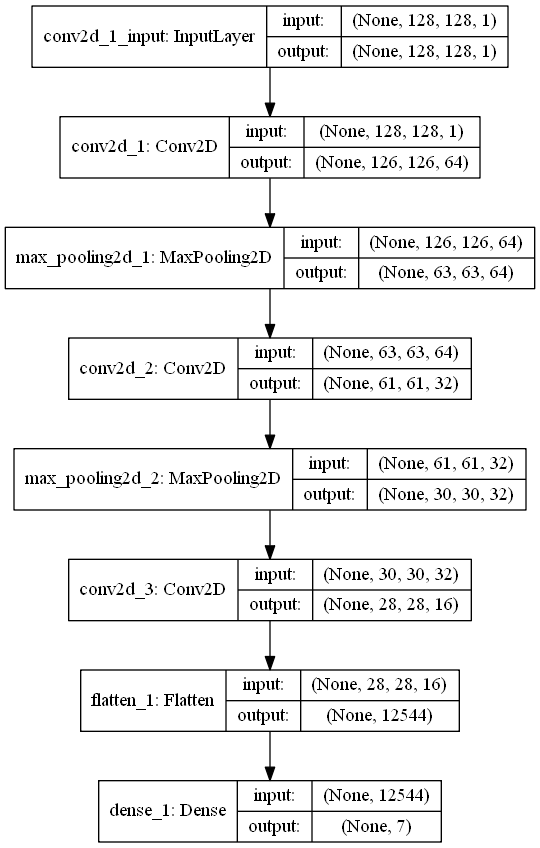

In [38]:
from keras.utils import plot_model

plot_model(model, to_file="cnn_model_plot.png", show_shapes=True, show_layer_names=True)

In [39]:
model.save("cnn-model-v2-save")